## Build and Evaluate a Linear Risk model

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
from assignments.C2_W1 import utils

DATA_DIR = "assignments/C2_W1/"
X = pd.read_csv(DATA_DIR + "X_data.csv", index_col=0)
y = pd.read_csv(DATA_DIR + "y_data.csv", index_col=0)
y = y['y']

### Exploring the Dataset

`X` includes:
- Age: (years)
- Systolic_BP: Systolic blood pressure (mmHg)
- Diastolic_BP: Diastolic blood pressure (mmHg)
- Cholesterol: (mg/DL)

In [5]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


The target `y` indicates whether or not the patient developed retinopathy:
- y = 1 : patient has retinopathy.
- y = 0 : patient does not have retinopathy.

In [6]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75)

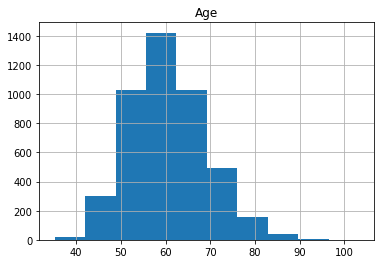

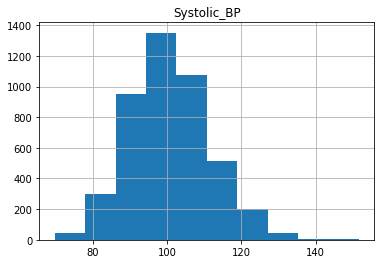

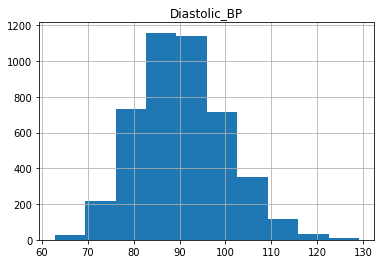

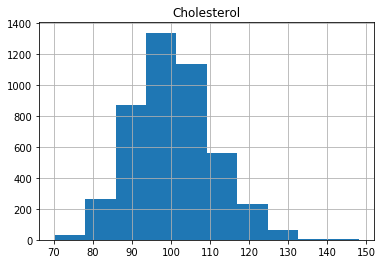

In [8]:
for col in X.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

As seen above, the distributions have a generally bell shaped distribution, but with slight rightward skew.

Many statistical models assume that data is normally distributed, forming a symmetric Gaussian bell shape (no skew), more like the example below.

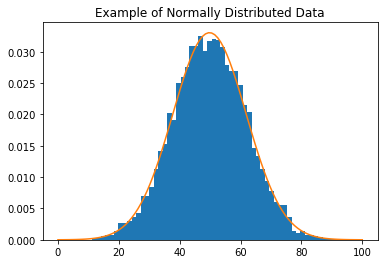

In [9]:
from scipy.stats import norm

data = np.random.normal(50, 12, 5000)
fitting_params = norm.fit(data)
norm_dist_fitted = norm(*fitting_params)
t = np.linspace(0, 100, 100)
plt.hist(data, bins=60, density=True)
plt.plot(t, norm_dist_fitted.pdf(t))
plt.title("Example of Normally Distributed Data")
plt.show()

Now removing the skew and transform the data to be closer to a normal distribution.

One way to remove the skew is by applying the log function to the data.

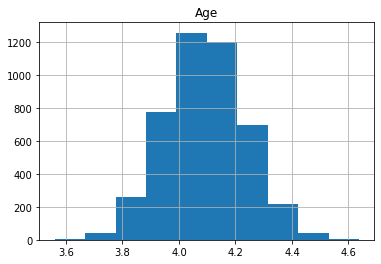

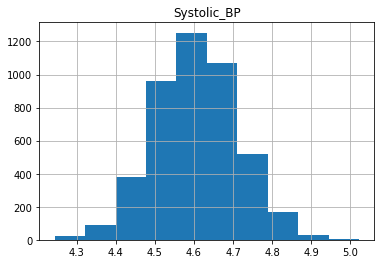

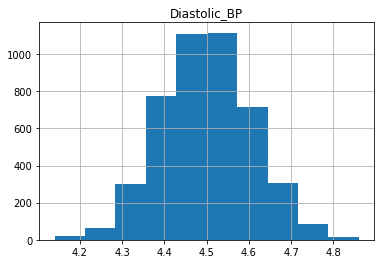

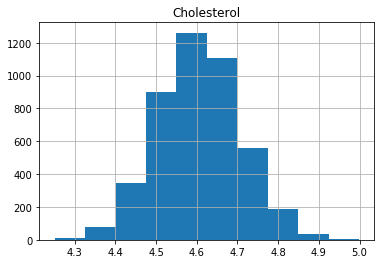

In [10]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

The data seems to be more symmetric after taking the log.

### Mean Normalizing the Data

Transforming the data so that the distributions are closer to standard normal distributions.

First I'll remove some of the skew from the distribution by using the log transformation.

Then we'll standarize the distribution so that it has a mean o 0 and standard

In [11]:
def make_standard_normal(df_train, df_test):
    df_train_unskewed = np.log(df_train)
    df_test_unskewed = np.log(df_test)

    mean = df_train_unskewed.mean()
    stdev = df_train_unskewed.std(ddof=1)
    
    df_train_standarized = (df_train_unskewed - mean) / stdev
    
    df_test_standarized = (df_test_unskewed - mean) / stdev
    
    return df_train_standarized, df_test_standarized 

In [12]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

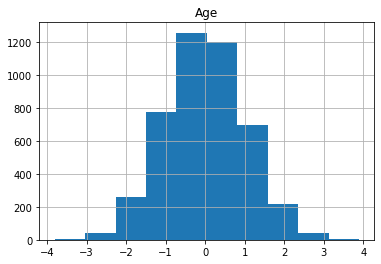

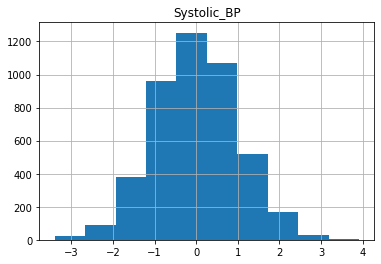

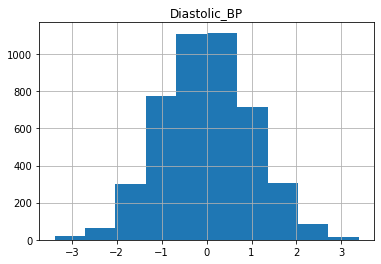

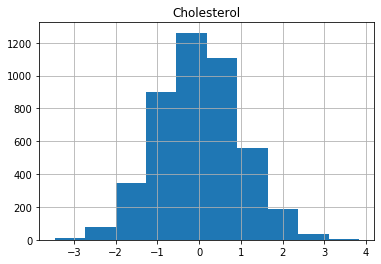

In [13]:
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

### Building the Model

In [14]:
def lr_model(X_train, y_train):
    from sklearn.linear_model import LogisticRegression
    
    model = LogisticRegression()
    
    model.fit(X_train, y_train)
    
    return model

In [15]:
model_X = lr_model(X_train, y_train)

### Evaluating using the C-index

- the c-index measures the discriminatory power of a risk score
- a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients
- the formula for the c-index is:

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$



- a **permissible pair** is a pair of patients who have different outcomes
- a **concordant pair** is a pair in which the patient with the higher risk score also has the worse outcome
- a **tie** is a permissible pair, where the patients have the same risk score

In [17]:
def cindex(y_true, scores):
    n = len(y_true)
    assert len(scores) == n
    
    concordant = 0
    permissible = 0
    ties = 0
    
    for i in range(n):
        for j in range(i+1, n):
            # is permissible?
            if y_true[i] != y_true[j]:
                permissible += 1
                
                if scores[i] == scores[j]:
                    ties += 1
                    continue
                    
            # case 1: patient i doesn't get the disease, pateint j does
            if y_true[i] == 0 and y_true[j] == 1:
                if scores[i] < scores[j]:
                    concordant += 1
                    
            # case 2: patient i does get the disease, pateint j does not
            if y_true[i] == 1 and y_true[j] == 0:
                if scores[i] > scores[j]:
                    concordant += 1
                    
    c_index = (concordant + 0.5*ties) / permissible
    
    return c_index

### Evaluating the Model on the Test Set

The `predict_proba` method will return the result from the model before it is converted to a binary 0 or 1.

For each input case, it returns an array of two values which represent the probabilities for both the negative case and positive case.

In [20]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(c_index_X_test)

0.80701136357571


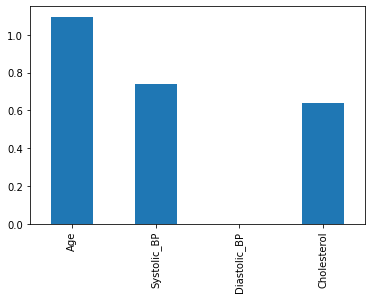

In [21]:
coeffs = pd.DataFrame(data=model_X.coef_, columns=X_train.columns)
coeffs.T.plot.bar(legend=None)

### Improving the Model

The model can be improved by including interaction terms.
**Interaction term is the product of two variables.**

* For example, if we have data 
    $$ x = [x_1, x_2]$$
* We could add the product so that:
    $$ \hat{x} = [x_1, x_2, x_1*x_2]$$

In [22]:
def add_interactions(X):
    features = X.columns
    m = len(features)
    X_int = X.copy(deep=True)
    
    for i in range(m):
        feature_i_name = features[i]
        feature_i_data = X[feature_i_name]
        
        for j in range(i+1, m):
            feature_j_name = features[j]
            feature_j_data = X[feature_j_name]
            
            feature_i_j_name = f"{feature_i_name}_x_{feature_j_name}"
            
            X_int[feature_i_j_name] = feature_i_data * feature_j_data 
            
    return X_int

In [23]:
X_train_int = add_interactions(X_train)
X_test_int = add_interactions(X_test)

### Evaluate the Improved Model

In [24]:
model_X_int = lr_model(X_train_int, y_train)

In [25]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(c_index_X_test)
print(c_index_X_int_test)

0.80701136357571
0.8135338105074378


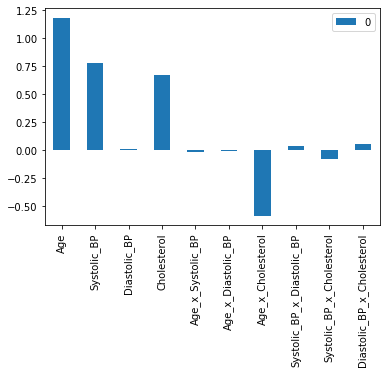

In [26]:
int_coeffs = pd.DataFrame(data=model_X_int.coef_, columns=X_train_int.columns)
int_coeffs.T.plot.bar()

Age, Systolic_BP and Cholesterol have a positive coefficient.

This means that a higher value in these three features leads to a higher prediction probability for the disease.

Interaction of Age x Cholesterol has a negative coefficient/ This means that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease. 

To better understand the effect of interaction terms, should we compare the output of the model that has been trained on sample cases with and without the interaction.

In [27]:
index = 1234
case = X_train_int.iloc[index, :]
print(case)

Age                          -0.698779
Systolic_BP                  -0.532250
Diastolic_BP                 -0.048946
Cholesterol                  -1.245706
Age_x_Systolic_BP             0.371925
Age_x_Diastolic_BP            0.034202
Age_x_Cholesterol             0.870473
Systolic_BP_x_Diastolic_BP    0.026051
Systolic_BP_x_Cholesterol     0.663027
Diastolic_BP_x_Cholesterol    0.060972
Name: 4266, dtype: float64


Age and Cholesterol is above average. What our original model would have output by zero-ing out the for Cholesterol and Age.

In [28]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                          -0.698779
Systolic_BP                  -0.532250
Diastolic_BP                 -0.048946
Cholesterol                  -1.245706
Age_x_Systolic_BP             0.371925
Age_x_Diastolic_BP            0.034202
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.026051
Systolic_BP_x_Cholesterol     0.663027
Diastolic_BP_x_Cholesterol    0.060972
Name: 4266, dtype: float64

In [33]:
print("Output with interaction: ", model_X_int.predict_proba([case.values])[:, 1][0])
print("Output without interaction: ", model_X_int.predict_proba([new_case.values])[:, 1][0])

Output with interaction:  0.06474257376773881
Output without interaction:  0.10359267082261066
